In [2]:
import pandas as pd
import wandb
import torch
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
# load own code
import sys
sys.path.append('../')
from sleeplib.Resnet_15.model import FineTuning
from sleeplib.datasets import BonoboDataset , ContinousToSnippetDataset
from sleeplib.montages import CDAC_bipolar_montage,CDAC_common_average_montage,CDAC_combine_montage
from sleeplib.transforms import cut_and_jitter, CDAC_bipolar_signal_flip,CDAC_monopolar_signal_flip
# this holds all the configuration parameters
from sleeplib.config import Config
import pickle


In [3]:
# define model name and path
model_path = 'Models/YOUR_MODEL_NAME'
# load config and show all default parameters
config = Config()
config.print_config()
# the config can be changed by setting config.PARAMETER = VALUE

# save config to model_path using pickle
with open(os.path.join(model_path, 'config.pkl'), 'wb') as f:
    pickle.dump(config, f)

THIS CONFIG FILE CONTAINS THE FOLLOWING PARAMETERS :

PATH_FILES_BONOBO /home/ubuntu/data/bonobo/npy1.5/
PATH_LUT_BONOBO /home/ubuntu/code/Spike_37chan/pseudo_test.csv
PATH_CONTINOUS_EEG /bdsp/staging/Bonobo/Datasets/continuousEEG
FQ 128
MONTAGE bipolar
WINDOWSIZE 1
N_FFT 128
HOP_LENGTH 64
HEAD_DROPOUT 0.3
EMB_SIZE 256
HEADS 8
DEPTH 4
N_CHANNELS 37
BATCH_SIZE 256
LR 0.01


In [16]:
# load dataset
df = pd.read_csv(config.PATH_LUT_BONOBO,sep=',')
# add transformations
transform_train_bipolar = transforms.Compose([cut_and_jitter(windowsize=config.WINDOWSIZE,max_offset=0.1,Fq=config.FQ), CDAC_bipolar_signal_flip(p=1)])
transform_train_common_average = transforms.Compose([cut_and_jitter(windowsize=config.WINDOWSIZE,max_offset=0.1,Fq=config.FQ), CDAC_monopolar_signal_flip(p=1)])
transform_val = transforms.Compose([cut_and_jitter(windowsize=config.WINDOWSIZE,max_offset=0,Fq=config.FQ)])#,CDAC_signal_flip(p=0)])
transform_val = transforms.Compose([cut_and_jitter(windowsize=config.WINDOWSIZE,max_offset=0,Fq=config.FQ)])#,CDAC_signal_flip(p=0)])

# init datasets
sub_df = df[df['total_votes_received']>2]
train_df = sub_df[sub_df['Mode']=='Train'][:20]
val_df = sub_df[sub_df['Mode']=='Val']

# set up dataloaders
bipolar_montage = CDAC_bipolar_montage()
common_average_montage = CDAC_common_average_montage()
combine_montage = CDAC_combine_montage()

Bonobo_train = BonoboDataset(train_df, config.PATH_FILES_BONOBO, 
                             transform_train_bipolar=transform_train_bipolar,
                             transform_train_common_average=transform_train_common_average, 
                             bipolar_montage=bipolar_montage, 
                             common_average_montage=common_average_montage,
                             combine_montage = combine_montage
                            )
train_dataloader = DataLoader(Bonobo_train, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

Bonobo_val = BonoboDataset(val_df, config.PATH_FILES_BONOBO, 
                           transform_train_bipolar=transform_val, 
                           transform_train_common_average=transform_val, 
                           bipolar_montage=bipolar_montage, 
                           common_average_montage=common_average_montage,
                           combine_montage = combine_montage
                          )
val_dataloader = DataLoader(Bonobo_val, batch_size=config.BATCH_SIZE,shuffle=False,num_workers=os.cpu_count())

#Bonobo_con = ContinousToSnippetDataset('/home/ubuntu/data/Bonobo01742_0.mat',montage=montage)#montage use numpy,so .mat maybe cannot do it
#con_dataloader = DataLoader(Bonobo_con, batch_size=config.BATCH_SIZE,shuffle=False,num_workers=os.cpu_count())


In [8]:
# build model
model = FineTuning(lr=config.LR,
                    head_dropout=config.HEAD_DROPOUT,
                    n_channels=config.N_CHANNELS,
                    n_fft=config.N_FFT,
                    hop_length=config.HOP_LENGTH)

# create a logger
wandb.init(dir='logging')
wandb_logger = WandbLogger(project='super_awesome_project') 

# create callbacks with early stopping and model checkpoint (saves the best model)
callbacks = [EarlyStopping(monitor='val_loss',patience=5),ModelCheckpoint(dirpath=model_path,filename='weights',monitor='val_loss')]
# create trainer, use fast dev run to test the code
trainer = pl.Trainer(devices=1, accelerator="gpu", min_epochs=20,logger=wandb_logger,callbacks=callbacks,fast_dev_run=False)
# train the model
trainer.fit(model,train_dataloader,val_dataloader)
wandb.finish()

/opt/conda/envs/eeg/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/eeg/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/opt/conda/envs/eeg/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/ubuntu/code/Spike_transformer/Models/YOUR_MODEL_NAME exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RAN

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=20` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch,▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
train_loss_epoch,██▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_loss_step,▇▅█▇▇▅▆▇▃▆▃▆▇▄▆▂▆█▄▂▄▄▇▅▂▃▆▅▇▃▁▃▁▄▄▇▂▄▄▄
trainer/global_step,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,▄▅▇▇██▇▇▇▅▄▂▃▃▃▃▄▄▂▁
epoch,19
train_loss_epoch,0.05611
train_loss_step,0.05729
trainer/global_step,2299
val_loss,0.0603


In [20]:
import scipy.io as sio
import numpy as np
import h5py
import pandas as pd
import os
'''
# load config and show all default parameters
config = Config()
df = pd.read_csv(config.PATH_LUT_BONOBO, sep=',')

length = len(df)
print(length)

# List to store indices of rows corresponding to files not found
indices_to_remove = []

for idx in range(0, length):
    event_file = df.iloc[idx]['event_file']
    mat_file_name = f"{event_file}.mat"
    path_signal = os.path.join('/home/ubuntu/data/bonobo/1.5/', mat_file_name)
    
    try:
        signal = h5py.File(path_signal, 'r')
        data = signal['seg']
        npy_file_name = f"{event_file}.npy"
        npy_file_path = os.path.join('/home/ubuntu/data/bonobo/npy1.5/', npy_file_name)
        # Save the matrix as .npy file
        np.save(npy_file_path, data)
        
    except FileNotFoundError:
        print(f"File {mat_file_name} not found. Marking for removal from dataframe.")
        indices_to_remove.append(idx)

# Drop rows from df where files were not found
df.drop(indices_to_remove, inplace=True)
df.reset_index(drop=True, inplace=True)


'''
import scipy.io as sio
import numpy as np
import h5py
# load config and show all default parameters
df = pd.read_csv('/home/ubuntu/code/Spike_37chan/lut_labelled_20230628.csv', sep=';')

length = len(df)
print(length)

for idx in range(0,length):
    event_file = df.iloc[idx]['event_file']
    # load signal of the idx-th sample
    mat_file_name = f"{event_file}.mat"
    path_signal = os.path.join('/home/ubuntu/data/bonobo/1.5/',mat_file_name)
    signal = h5py.File(path_signal,'r')
    data = signal['seg']
    npy_file_name = f"{event_file}.npy"
    npy_file_path = os.path.join('/home/ubuntu/data/bonobo/pseudo/', npy_file_name)
    # Save the matrix as .npy file
    np.save(npy_file_path, data)




32433


In [7]:
length = len(df)
print(length)

709144


In [8]:
output_path = '/home/ubuntu/code/Spike_37chan/pseudo.csv'
df.to_csv(output_path, index=False)

In [17]:

import numpy as np
model = FineTuning.load_from_checkpoint('/home/ubuntu/code/Spike_37chan/Models/YOUR_MODEL_NAME/37chan_weights-v6.ckpt',
                                        lr=config.LR,
                                        head_dropout=config.HEAD_DROPOUT,
                                        n_channels=config.N_CHANNELS,
                                        n_fft=config.N_FFT,
                                        hop_length=config.HOP_LENGTH,
                                       )
                                        #map_location=torch.device('cpu') add this if running on CPU machine
# init trainer
trainer = pl.Trainer(fast_dev_run=False,enable_progress_bar=False)

preds = trainer.predict(model,train_dataloader)
preds = np.concatenate(preds)

# store results
results = train_df[['event_file','fraction_of_yes','total_votes_received','Mode']].copy()
results['preds'] = preds
results.to_csv(path_model+'/predictions_train.csv',index=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/eeg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


NameError: name 'path_model' is not defined

<Axes: >

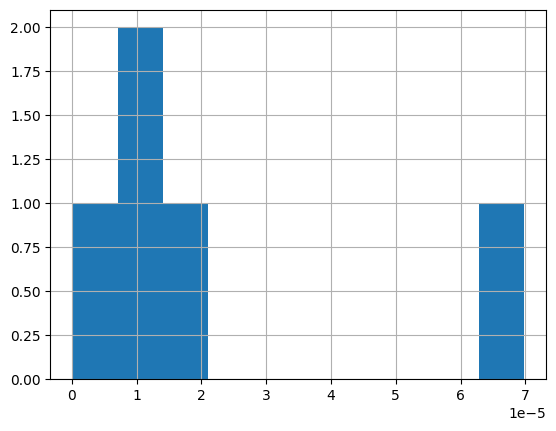

In [18]:
results.preds.hist()

In [15]:
preds.shape

(30647, 1)